### Creating Model 1

* Creating a 1st model for the NFL Play data. The goal is to predict the play type on 4th down.
* Random Forest and gradient boosted trees are the other models

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [4]:
# get the spark session and data frame
data = GetSparkDF(end_year = 2023, include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/07 22:08:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 22:08:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/07 22:08:25 WARN TaskSetManager: Stage 0 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:08:27 WARN TaskSetManager: Stage 3 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:08:34 WARN TaskSetManager: Stage 4 contains a task of very large size (3171 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:08:37 WARN TaskSetManager: Stage 5 contains a task of very large size (1930 KiB). The maximum recommended task size is 1000 KiB.


In [5]:
spark, df, test_df, undersample_df = data

In [7]:
# get 2023 season data that was withheld to use as another test set
test_df_2023 = get_2023_season_test_df()

2023 done.


In [8]:
df = df.drop('season')
test_df_2023 = test_df_2023.drop('season')

### Create numeric columns list for the pipeline

In [9]:
numeric_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()":
        numeric_cols.append(field.name)
        
#numeric_cols.remove("season")
numeric_cols.remove("week")

In [10]:
print(numeric_cols)

['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'drive', 'qtr', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa', 'wind', 'temp']


### Create the Model Pipeline

In [12]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", 'roof_vec', 'surface_vec']

# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# one hot encode categorical features from string indexer
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model

# Use Logistic Regression Classifier
lr = LogisticRegression(labelCol='play_type_idx', 
                        featuresCol='scaledFeatures')

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, lr])

In [13]:
# Set up hyperparameter tuning
# hyperparameter search across regularization and iterations
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0,  0.005, 0.01, 0.05, 0.09, 0.1]) \
    .addGrid(lr.maxIter, [10, 25, 50])\
    .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.5, 0.8, 0.85, 0.9, 1])\
    .build()

# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [14]:
df.select(df.roof).distinct().show()

24/12/07 22:10:25 WARN TaskSetManager: Stage 6 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [15]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

# fit the model with the hyperparameter search
lr_model = tvs.fit(df)

24/12/07 22:10:29 WARN TaskSetManager: Stage 9 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:31 WARN TaskSetManager: Stage 12 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:34 WARN TaskSetManager: Stage 15 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:36 WARN TaskSetManager: Stage 16 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/07 22:10:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/07 22:10:38 WARN TaskSetManager: Stage 17 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:38 WARN TaskSetManager: Stage 18 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:38 WARN TaskSetManager: Stage 19 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:38 WARN TaskSetManager: Stage 20 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:39 WARN TaskSetManager: Stage 21 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:39 WARN TaskSetManager: Stage 22 contains a task of very large s

24/12/07 22:10:42 WARN TaskSetManager: Stage 29 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:42 WARN TaskSetManager: Stage 32 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:43 WARN TaskSetManager: Stage 35 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:44 WARN TaskSetManager: Stage 36 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:45 WARN TaskSetManager: Stage 37 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:45 WARN TaskSetManager: Stage 38 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:45 WARN TaskSetManager: Stage 39 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:46 WARN TaskSetManager: Stage 40 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:46 WARN TaskSetManager: Stage 41 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:46 WARN TaskSetManager: Stage 42 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:46 WARN TaskSetManager: Stage 43 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/

24/12/07 22:10:49 WARN TaskSetManager: Stage 55 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:50 WARN TaskSetManager: Stage 56 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 57 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 58 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 59 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 60 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 61 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:51 WARN TaskSetManager: Stage 62 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/

24/12/07 22:10:54 WARN TaskSetManager: Stage 75 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:54 WARN TaskSetManager: Stage 76 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:10:55 WARN TaskSetManager: Stage 77 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 78 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 79 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 80 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 81 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 82 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:55 WARN TaskSetManager: Stage 83 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/

24/12/07 22:10:59 WARN TaskSetManager: Stage 97 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 98 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 99 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 100 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 101 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 102 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:10:59 WARN TaskSetManager: Stage 103 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24

24/12/07 22:11:02 WARN TaskSetManager: Stage 115 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:11:02 WARN TaskSetManager: Stage 116 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:11:03 WARN TaskSetManager: Stage 117 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 118 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 119 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 120 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 121 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 122 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:03 WARN TaskSetManager: Stage 123 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.

24/12/07 22:11:14 WARN TaskSetManager: Stage 193 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 194 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 195 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 196 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 197 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 198 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:11:14 WARN TaskSetManager: Stage 199 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.

24/12/07 22:14:51 WARN TaskSetManager: Stage 2528 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2529 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2530 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2531 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2532 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2533 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:14:51 WARN TaskSetManager: Stage 2534 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:15:17 WARN TaskSetManager: Stage 2822 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2823 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2824 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2825 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2826 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2827 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:17 WARN TaskSetManager: Stage 2828 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:15:19 WARN TaskSetManager: Stage 2844 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:19 WARN TaskSetManager: Stage 2845 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:20 WARN TaskSetManager: Stage 2846 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:20 WARN TaskSetManager: Stage 2847 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:20 WARN TaskSetManager: Stage 2848 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:20 WARN TaskSetManager: Stage 2849 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:20 WARN TaskSetManager: Stage 2850 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:15:22 WARN TaskSetManager: Stage 2866 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:22 WARN TaskSetManager: Stage 2867 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:22 WARN TaskSetManager: Stage 2868 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:22 WARN TaskSetManager: Stage 2869 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:22 WARN TaskSetManager: Stage 2870 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:23 WARN TaskSetManager: Stage 2871 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:23 WARN TaskSetManager: Stage 2872 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:15:25 WARN TaskSetManager: Stage 2888 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:25 WARN TaskSetManager: Stage 2889 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:25 WARN TaskSetManager: Stage 2890 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:25 WARN TaskSetManager: Stage 2891 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:25 WARN TaskSetManager: Stage 2892 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:25 WARN TaskSetManager: Stage 2893 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:26 WARN TaskSetManager: Stage 2894 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:15:52 WARN TaskSetManager: Stage 3158 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3159 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3160 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3161 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3162 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3163 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:15:52 WARN TaskSetManager: Stage 3164 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:16:13 WARN TaskSetManager: Stage 3411 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:13 WARN TaskSetManager: Stage 3412 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:13 WARN TaskSetManager: Stage 3413 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:13 WARN TaskSetManager: Stage 3414 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:14 WARN TaskSetManager: Stage 3415 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:14 WARN TaskSetManager: Stage 3416 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:14 WARN TaskSetManager: Stage 3417 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:16:18 WARN TaskSetManager: Stage 3463 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3464 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3465 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3466 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3467 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3468 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:18 WARN TaskSetManager: Stage 3469 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:16:46 WARN TaskSetManager: Stage 3788 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3789 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3790 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3791 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3792 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3793 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:16:46 WARN TaskSetManager: Stage 3794 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:17:26 WARN TaskSetManager: Stage 4236 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4237 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4238 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4239 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4240 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4241 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:17:26 WARN TaskSetManager: Stage 4242 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:18:11 WARN TaskSetManager: Stage 4710 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4711 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4712 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4713 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4714 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4715 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:18:11 WARN TaskSetManager: Stage 4716 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

24/12/07 22:19:05 WARN TaskSetManager: Stage 5339 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:19:07 WARN TaskSetManager: Stage 5340 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:19:08 WARN TaskSetManager: Stage 5341 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:08 WARN TaskSetManager: Stage 5342 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:09 WARN TaskSetManager: Stage 5343 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:09 WARN TaskSetManager: Stage 5344 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:09 WARN TaskSetManager: Stage 5345 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:09 WARN TaskSetManager: Stage 5346 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:19:09 WARN TaskSetManager: Stage 5347 contains a task of very large size (9052 KiB). The maximum recommended task size is 10

### Evaluate the Model

In [16]:
best_model = lr_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: scaledFeatures
fitIntercept: True
labelCol: play_type_idx
maxBlockSizeInMB: 0.0
maxIter: 25
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.0
standardization: True
threshold: 0.5
tol: 1e-06


In [17]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

test_df_2023 = test_df_2023.withColumn(
    'surface',
    F.when(test_df_2023.surface == '', 'Undefined').otherwise(test_df_2023.surface)
)

prediction = best_model.transform(test_df)
prediction2 = best_model.transform(test_df_2023)

In [20]:
from pyspark.sql.functions import round
prediction.select([prediction.home_team, prediction.posteam, prediction.defteam, prediction.posteam_score, prediction.defteam_score, prediction.yardline_100, prediction.side_of_field, prediction.ydstogo, \
                   round(prediction.quarter_seconds_remaining/60,2).alias("quarter min remaining"), prediction.qtr,prediction.play_type_idx, prediction.play_type, prediction.season ,prediction.prediction]) \
    .where((prediction.posteam=="BAL")).show(3)

24/12/07 22:24:30 WARN TaskSetManager: Stage 5381 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:31 WARN TaskSetManager: Stage 5382 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+------+----------+
|home_team|posteam|defteam|posteam_score|defteam_score|yardline_100|side_of_field|ydstogo|quarter min remaining|qtr|play_type_idx| play_type|season|prediction|
+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+------+----------+
|      ARI|    BAL|    ARI|         10.0|          7.0|        25.0|          ARI|    1.0|                 0.97|3.0|          1.0|field_goal|  2000|       1.0|
|      BAL|    BAL|    CAR|          7.0|         10.0|        60.0|          BAL|    6.0|                 3.23|2.0|          0.0|      punt|  2006|       0.0|
|      BAL|    BAL|    LAC|          0.0|          0.0|        58.0|          BAL|    5.0|                12.05|1.0|          0.0|      punt|  2018|       0.0|
+---------+-------+-------+-------------

In [19]:
from pyspark.sql.functions import round
prediction2.select([prediction2.home_team, prediction2.posteam, prediction2.defteam, prediction2.posteam_score, prediction2.defteam_score, prediction2.yardline_100, prediction2.side_of_field, prediction2.ydstogo, \
                   round(prediction2.quarter_seconds_remaining/60,2).alias("quarter min remaining"), prediction2.qtr,prediction2.play_type_idx, prediction2.play_type ,prediction2.prediction]) \
    .where((prediction2.posteam=="BAL")  & (prediction2.play_type_idx != prediction2.prediction)).show(20)

+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+----------+
|home_team|posteam|defteam|posteam_score|defteam_score|yardline_100|side_of_field|ydstogo|quarter min remaining|qtr|play_type_idx| play_type|prediction|
+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+----------+
|      BAL|    BAL|    IND|         14.0|         16.0|        32.0|          IND|    2.0|                 7.63|4.0|          1.0|field_goal|       3.0|
|      BAL|    BAL|    IND|         19.0|         19.0|        43.0|          IND|    2.0|                  0.1|4.0|          1.0|field_goal|       2.0|
|      BAL|    BAL|    IND|         19.0|         19.0|        47.0|          IND|    3.0|                 3.42|5.0|          2.0|      pass|       0.0|
|      CLE|    BAL|    CLE|         28.0|          3.0|        63.0|          BAL|

### Original Test Set Analysis

In [21]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)
precision = weighted_precision_eval.evaluate(prediction)
recall = weighted_recall_eval.evaluate(prediction)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)

24/12/07 22:24:38 WARN TaskSetManager: Stage 5390 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:24:39 WARN TaskSetManager: Stage 5391 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:41 WARN TaskSetManager: Stage 5400 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:42 WARN TaskSetManager: Stage 5401 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:45 WARN TaskSetManager: Stage 5410 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:46 WARN TaskSetManager: Stage 5411 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:48 WARN TaskSetManager: Stage 5420 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:24:48 WARN TaskSetManager: Stage 5421 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:24:50 WARN TaskSetManager: Stage 5430 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:24:51 WARN TaskSetManager: Stage 5431 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.



F1: 0.8478128304568765
Accuracy: 0.8685327709457423
Precision by Label: 0.9296651078594056
Weighted Precision: 0.8304202689986839
Weighted Recall: 0.8685327709457423



In [22]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('play_type_idx')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/07 22:25:01 WARN TaskSetManager: Stage 5440 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:25:01 WARN TaskSetManager: Stage 5441 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


[[2.4651e+04 2.8200e+02 3.2900e+02 2.0300e+02 4.0000e+00]
 [1.5300e+02 5.5430e+03 2.3900e+02 1.0400e+02 0.0000e+00]
 [5.3900e+02 5.5000e+02 9.7600e+02 2.1100e+02 4.0000e+00]
 [3.1500e+02 3.7700e+02 1.4600e+02 5.4100e+02 0.0000e+00]
 [8.5800e+02 2.9100e+02 1.0500e+02 9.0000e+01 0.0000e+00]]


In [23]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x[0] for x in labels]

24/12/07 22:25:26 WARN TaskSetManager: Stage 5464 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:25:27 WARN TaskSetManager: Stage 5465 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


Text(95.58159722222221, 0.5, 'Actual')

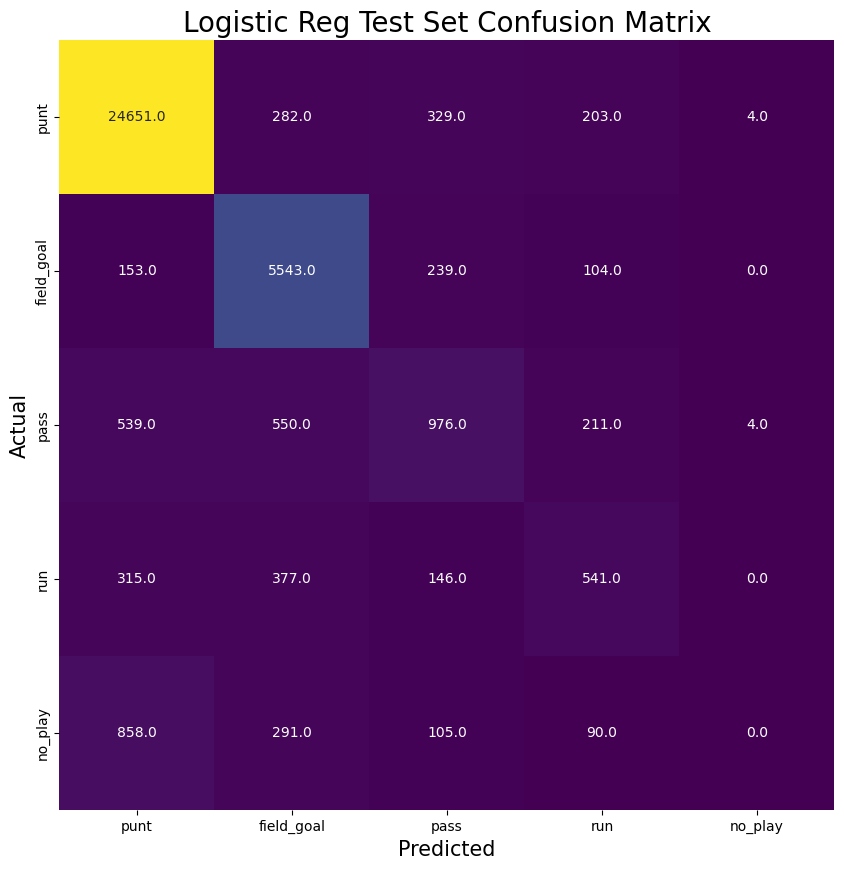

In [24]:
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Logistic Reg Test Set Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
#plt.savefig('lg2023-normal-confusion-matrix.png')

In [25]:
prediction.groupby(prediction.prediction).count().show()

24/12/07 22:25:42 WARN TaskSetManager: Stage 5489 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:25:43 WARN TaskSetManager: Stage 5490 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|26516|
|       1.0| 7043|
|       4.0|    8|
|       3.0| 1149|
|       2.0| 1795|
+----------+-----+



In [26]:
prediction.select(prediction.play_type, prediction.play_type_idx).groupby([prediction.play_type,prediction.play_type_idx]).count().show()

24/12/07 22:25:59 WARN TaskSetManager: Stage 5503 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:25:59 WARN TaskSetManager: Stage 5504 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------+-----+
| play_type|play_type_idx|count|
+----------+-------------+-----+
|      punt|          0.0|25469|
|   no_play|          4.0| 1344|
|field_goal|          1.0| 6039|
|       run|          3.0| 1379|
|      pass|          2.0| 2280|
+----------+-------------+-----+



In [27]:
prediction.groupby(prediction.play_type_idx).count().show()

24/12/07 22:26:04 WARN TaskSetManager: Stage 5517 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:26:05 WARN TaskSetManager: Stage 5518 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0|25469|
|          1.0| 6039|
|          4.0| 1344|
|          3.0| 1379|
|          2.0| 2280|
+-------------+-----+



### 2023 Season Test Set Analysis

In [28]:
labels = prediction2.select([prediction2.play_type, prediction2.play_type_idx]).distinct().orderBy(prediction2.play_type_idx).select(prediction2.play_type).collect()
labels = [x[0] for x in labels]

In [29]:
test_df.groupby(test_df.play_type).count().show()

24/12/07 22:26:27 WARN TaskSetManager: Stage 5539 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:26:28 WARN TaskSetManager: Stage 5540 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|11893|
|   no_play| 2624|
|       run| 2604|
|      punt|40019|
|      pass| 4350|
+----------+-----+



In [32]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction2)
accuracy = accuracy_evaluator.evaluate(prediction2)
precision_by_label = precision_by_label_eval.evaluate(prediction2)
precision = weighted_precision_eval.evaluate(prediction2)
recall = weighted_recall_eval.evaluate(prediction2)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)



F1: 0.7505767402454944
Accuracy: 0.7899960301707026
Precision by Label: 0.840625
Weighted Precision: 0.7515044294482254
Weighted Recall: 0.7899960301707026



In [33]:
#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction2.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('play_type_idx')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1.345e+03 4.000e+00 2.100e+01 6.000e+00 0.000e+00]
 [2.300e+01 4.950e+02 2.800e+01 9.000e+00 0.000e+00]
 [9.800e+01 6.500e+01 7.900e+01 3.400e+01 1.000e+00]
 [4.900e+01 3.300e+01 1.500e+01 7.000e+01 0.000e+00]
 [8.500e+01 2.200e+01 2.200e+01 1.400e+01 1.000e+00]]


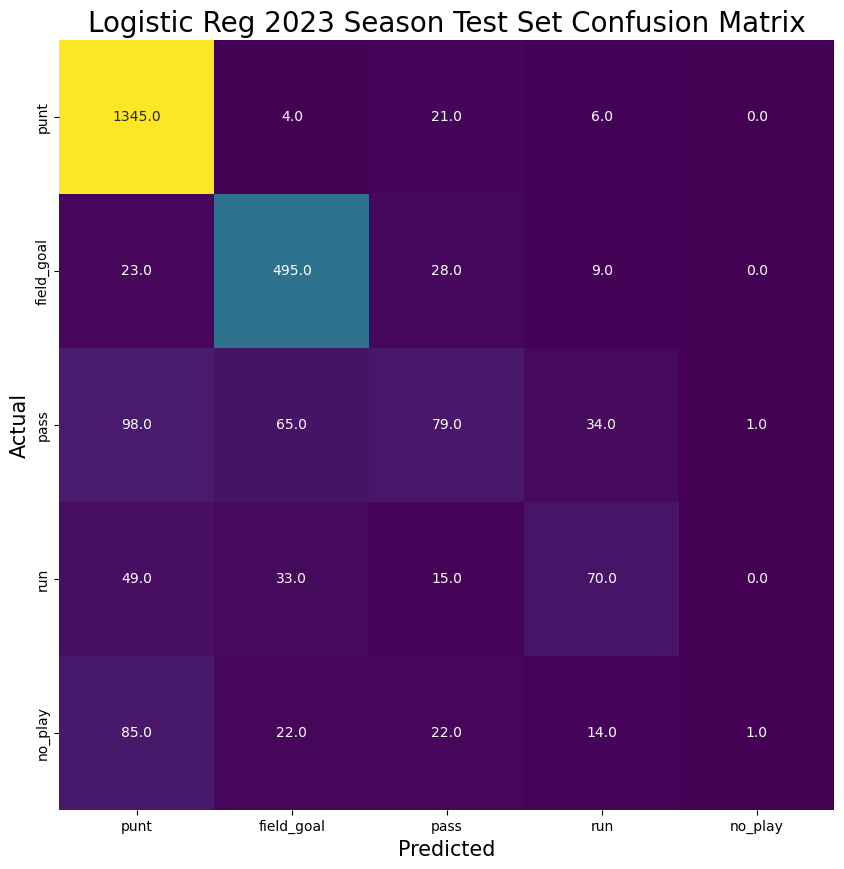

In [34]:
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Logistic Reg 2023 Season Test Set Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('lg2023-normal-confusion-matrix.png')

### Conclusions

Some quick observations:

* Good at pedicting punts and field goals.
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors